#### Data Analysis 2

### Assignment 1
Alejandra Savage Briz
 
Central European University



**Unconditional gender gap and its variation with the level of education**

Using the cps-earnings dataset and the morg-2014-emp.csv

#### Importing py_helper_funtions

In [1]:
# Import packages
####################################################
import copy
from typing import List

import numpy as np
import numpy.typing as npt
import pandas as pd
from plotnine import *

####################################################
# Define global vars
####################################################
color = ["#3a5e8cFF", "#10a53dFF", "#541352FF", "#ffcf20FF", "#2f9aa0FF"]


####################################################
# Define helper functions
####################################################
def seq(start: float, stop: float, by: float, round_n=3) -> list:
    """
    Custom function, used for setting the breaks of plotnine scales.

       Parameters
    ----------
    start : float
        Start of the breaks.
    stop : float
        End of the breaks.
    by : float
        Steps between breaks.
    round_n: int, default=3
        Decimals to round floats in output.
    """
    epsilon = np.finfo("float").eps

    return [
        round(x, round_n) for x in list(np.arange(start, stop + (by - epsilon), by))
    ]


def skew(l: npt.ArrayLike, round_n=3) -> float:
    return round((np.mean(l) - np.median(l)) / np.std(l), round_n)


def knot_ceil(vector: np.array, knot: float) -> np.array:
    vector_copy = copy.deepcopy(vector)
    vector_copy[vector_copy > knot] = knot
    return vector_copy


def lspline(series: pd.Series, knots: List[float]) -> np.array:
    """
    Function to create design matrix to esitmate a piecewise
    linear spline regression.

       Parameters
    ----------
    series : pd.Series
        Your variable in a pandas Series.
    knots : List[float]
        The knots, that result in n + 1 line segments.
    """

    if type(knots) != list:
        knots = [knots]
    design_matrix = None
    vector = series.values

    for i in range(len(knots)):
        # print(i)
        # print(vector)
        if i == 0:
            column = knot_ceil(vector, knots[i])
        else:
            column = knot_ceil(vector, knots[i] - knots[i - 1])
        # print(column)
        if i == 0:
            design_matrix = column
        else:
            design_matrix = np.column_stack((design_matrix, column))
        # print(design_matrix)
        vector = vector - column
    design_matrix = np.column_stack((design_matrix, vector))
    # print(design_matrix)
    return design_matrix


def create_calibration_plot(
    data: pd.DataFrame,
    file_name: str,
    prob_var: str,
    actual_var: str,
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
):
    """
    Function to create calibration curve.
    Returns calibration curve on a plot.

       Parameters
    ----------
    data : pd.DataFrame
        Your dataframe, containing the actual outcome and
        the predicted probabilities of that outcome
        by a model.
    file_name : str
        Filename to save. NOTE: this is note used for now.
    prob_var : str
        Name of the variable, containin predicted
        probabilities.
    actual_var : str
        Name of the actual outcome variable.
    y_lab: str
        Label on y axis of the plot.
    n_bins : int, default=10
        The number of bins, you would like to create.
        This is because with many values for the predicted probabilities,
        we may have few observations to look at for each value.
    breaks (optional): list or None
        You can speficy the breaks of the plot.
    """

    if breaks is None:
        breaks = np.around(
            np.linspace(0, (n_bins + 1) / 10, num=n_bins + 1, endpoint=False),
            decimals=1,
        ).tolist()

    data["prob_bin"] = pd.cut(data[prob_var], breaks, right=True, include_lowest=True)

    binned_data = (
        data.groupby("prob_bin")
        .agg(
            mean_prob=(prob_var, "mean"),
            mean_actual=(actual_var, "mean"),
            n=(actual_var, "size"),
        )
        .reset_index()
    )

    return (
        ggplot(binned_data, aes("mean_prob", "mean_actual"))
        + geom_line(color=color[0], size=1, show_legend=True)
        + geom_point(color=color[0], size=1, alpha=0.7, show_legend=False, na_rm=True)
        + geom_segment(
            x=min(breaks),
            xend=max(breaks),
            y=min(breaks),
            yend=max(breaks),
            color=color[1],
            size=0.5,
        )
        + theme_bw()
        + labs(x="Predicted event probability", y=y_lab)
        + coord_cartesian(xlim=(0, 1), ylim=(0, 1))
        + expand_limits(x=0.01, y=0.01)
        + scale_y_continuous(expand=(0.01, 0.01), breaks=(seq(0, 1.1, 0.1)))
        + scale_x_continuous(expand=(0.01, 0.01), breaks=(seq(0, 1.1, 0.1)))
    )


def poly(x: npt.ArrayLike, degree=1) -> pd.DataFrame:
    """
    Fit polynomial.

    These are non orthogonal factors, but it may not matter if
    we only need this for predictions (without interpreting the
    coefficients) or visualisation.

    Parameters
    ----------
    x : npt.ArrayLike
        Data array.
    degree : int, default=1
        Degree of the polynomial.
    """
    d = {}
    for i in range(degree + 1):
        if i == 1:
            d["x"] = x
        else:
            d[f"x**{i}"] = np.power(x, i)
    return pd.DataFrame(d)


def price_diff_by_variables(
    df: pd.DataFrame, factor_var: str, dummy_var: str, factor_lab: str, dummy_lab: str
) -> ggplot:
    """
    Price difference by selected factor and dummy variables.

    This function creates a barplots looking for interactions.
    Used in `ch14-airbnb-prediction.ipynb`.

        Parameters
    ----------
    df : pd.DataFrame
        Your dataframe.
    factor_var : str
        Your factor variable (like room_type).
    dummy_var : str
        The dummy variable you are interested in (like TV).
    factor_lab : str
        The label on the final plot for the `factor_var`.
    dummy_lab : str
        The label on the final plot for the `dummy_var`.
    """

    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("price", np.mean), sd=("price", np.std), size=("price", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1 / 2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()

    return (
        ggplot(
            stats,
            aes(
                stats.columns[0],
                stats.columns[2],
                fill="factor(" + stats.columns[1] + ")",
            ),
        )
        + geom_bar(stat="identity", position=position_dodge(width=0.9))
        + geom_errorbar(
            aes(ymin="Mean_l", ymax="Mean_u"),
            position=position_dodge(width=0.9),
            width=0.25,
        )
        + scale_color_manual(name=dummy_lab, values=(color[1], color[0]))
        + scale_fill_manual(name=dummy_lab, values=(color[1], color[0]))
        + ylab("Mean Price")
        + xlab(factor_lab)
        + theme_bw()
        + theme(
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),
            axis_line=element_line(),
            legend_position="top",
            legend_box="vertical",
            legend_text=element_text(size=5),
            legend_title=element_text(size=5, face="bold"),
        )
    )


import statsmodels.formula.api as smf
from sklearn.model_selection import KFold
from statsmodels.tools.eval_measures import rmse


def ols_crossvalidator(
    formula: str, data: pd.DataFrame, n_folds=5, average_rmse=True
) -> dict:
    """OLS cross-validator


    Estimates `formula` equation with OLS and returns values of RMSE, R`2, No. coefficients,
    BIC on `data`. Does k-fold cross-validation and either returns train and test RMSE for each
    fold, or return averarage train and test RMSEs.

    Parameters
    ----------
    formula : str
        Equation that is estimated by OLS.
    data : pd.DataFrame
        Database in a wide format.
    n_folds : int, default=5
        Number of folds. Must be at least 2.
    average_rmse : bool, default=True
        Whether to return the average train and test RMSE of the k-fold CV, or return
        train and test RMSE-s for each fold.

    """

    # Get dependent variable

    y = formula.split("~")[0].strip()

    # Get statistics on the whole work data

    model = smf.ols(formula, data=data).fit()

    rsquared = model.rsquared
    # n_coefficients = model.params.shape[0]
    n_coefficients = (
        model.df_model + 1
    )  # This might differ from model.params.shape[0], because of collinear predictors
    bic = model.bic
    rmse_alldata = rmse(model.predict(), data[y])

    # Calculating test and train RMSE-s for each fold

    k = KFold(n_splits=n_folds, shuffle=False, random_state=None)

    rmse_train = []
    rmse_test = []

    for train_index, test_index in k.split(data):

        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]

        model = smf.ols(formula, data=data_train).fit()

        rmse_train.append(rmse(data_train[y], model.predict(data_train)))
        rmse_test.append(rmse(data_test[y], model.predict(data_test)))

    if average_rmse:
        rmse_train = np.mean(rmse_train)
        rmse_test = np.mean(rmse_test)

    return {
        "RMSE": rmse_alldata,
        "R-squared": rsquared,
        "BIC": bic,
        "Coefficients": n_coefficients,
        "Training RMSE": rmse_train,
        "Test RMSE": rmse_test,
    }


import statsmodels


def point_predict_with_conf_int(
    regression: statsmodels.regression.linear_model.RegressionResultsWrapper,
    new_datapoint: pd.DataFrame,
    interval_precision=0.95,
    round_n=2,
) -> dict:
    """
    Does point prediction and interval prediction for a new datapoint.

        Parameters
    ----------
    regression : statsmodels.regression.linear_model.RegressionResultsWrapper
        Fitted regression model.
    new_datapoint : pd.DataFrame
        Database containing a new observation.
    interval_precision : float, default=0.95
        Precision of interval prediction.
    round_n: int, default=2
        Decimals to round floats in output.
    """

    summaryframe = regression.get_prediction(new_datapoint).summary_frame(
        alpha=1 - interval_precision
    )

    point_prediction = round(summaryframe["mean"].values[0], round_n)

    conf_int = [
        round(i, round_n)
        for i in summaryframe[["obs_ci_lower", "obs_ci_upper"]].values[0]
    ]

    if round_n == 0:
        point_prediction = int(point_prediction)
        conf_int = [int(i) for i in conf_int]
    else:
        pass

    return {
        "Point prediction": point_prediction,
        f"Prediction Interval ({round(interval_precision*100)}%)": conf_int,
    }


class Error(Exception):
    """Base class for other exceptions"""

    pass


class ConfintError(Error):
    """
    Error raised when a confidence interval
    does not match with required format.
    """

    def __init__(
        self,
        message="Confidence intervals are two numbers, so len(conf_int) must be 2.",
    ):
        self.message = message
        super().__init__(self.message)


def format_confidence_interval(conf_int: List[float], round_n=2) -> str:
    """Format confidence interval.

        Parameters
    ----------
    conf_int: np.array
        Array, consisting upper and upper confidence interval values.
    round_n: int, default=2
        Decimals to round floats in output.
    """
    if len(conf_int) != 2:
        raise ConfintError
    elif round_n == 0:
        return "[" + "–".join([str(int(round(i, round_n))) for i in conf_int]) + "]"
    else:
        return "[" + "–".join([str(round(i, round_n)) for i in conf_int]) + "]"


def create_sample_frame(
    vector: np.array, sample_size: int, n_samples=10000, with_replacement=False, seed=42
) -> List[np.array]:
    """
    Function for a specified number of samples.
    Draws a specified number of observations from a vector, either with or without replacement.
    Returns the matrix of samples.

    Used in `ch05-stock-market-loss-generalize.ipynb`

       Parameters
    ----------
    vector : np.array
        Vector of observations.
    sample_size : int
        Sample size, you want to draw.
        Set it len(vector) for bootstrap sampling.
    n_samples : int, default=10000
        Number of samples.
    with_replacement : bool, default=False
        Whether to perform sampling with or without
        replacement. Set `True` for bootstrap sampling.
    seed : int,default=42
        Random seed for reproducibility.
    """

    rng = np.random.default_rng(seed)
    sample_frame = np.zeros((n_samples, sample_size))
    for i in range(n_samples):
        sample_frame[i] = rng.choice(vector, size=sample_size, replace=with_replacement)

    return sample_frame


def add_margin(ax, x=0.05, y=0.05) -> None:
    """
    This will, by default, add 5% to the x and y margins to matplotlib plots.
    You can customise this using the x and y arguments when you call it.

       Parameters
    ----------
    ax : matplotlib.axes._subplots.AxesSubplot
        Vector of observations.
    x : float,default=0.05
        Margin to add for x axis.
    y : float,default=0.05
        Margin to add for x axis.
    """

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xmargin = (xlim[1] - xlim[0]) * x
    ymargin = (ylim[1] - ylim[0]) * y

    ax.set_xlim(xlim[0] - xmargin, xlim[1] + xmargin)
    ax.set_ylim(ylim[0] - ymargin, ylim[1] + ymargin)

#### Importing libraries

In [2]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mizani import transforms
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

warnings.filterwarnings("ignore")

#### Loading dataset

In [3]:
data_all = pd.read_csv("morg-2014-emp.csv")

-CPS 2014: representative sample of all people age 15-85 in USA in 2014.Current Population Survey of the USA on adult population (already cleaned dataset)

### SELECT OCCUPATION

Keeping only two occupation types: Financial Managers (**0120**) and Financial Specialists (**0800-0950**)

(for this case study we start with Financial Managers)

In [4]:
data_all.loc[data_all["occ2012"] == 120, "sample"] = 1 # Financial Managers
# sample == 1
data_all.loc[
    ((data_all["occ2012"] >= 800) & (data_all["occ2012"] <= 950)), "sample"
] = 2 # Financial Specialists
# sample == 2
data_all.loc[data_all["sample"].isna(), "sample"] = 0 # were NAs input zeros
# sample == 0
data_all

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94,sample
0,3,2600310997690,January,AL,3151.6801,1692.00,40,43,1,NaN,...,0,"Native, Born In US",63,Employment services (5613),630,"Private, For Profit",No,No,Employed-At Work,0.0
1,5,75680310997590,January,AL,3457.1138,450.00,40,41,2,NaN,...,6,"Native, Born In US",63,Outpatient care centers (6214),5400,"Private, For Profit",No,No,Employed-Absent,0.0
2,6,75680310997590,January,AL,3936.9110,1090.00,60,41,2,NaN,...,6,"Native, Born In US",63,Motor vehicles and motor vehicle equipment man...,8140,"Private, For Profit",No,No,Employed-At Work,0.0
3,10,179140131100930,January,AL,3288.3640,769.23,40,40,1,NaN,...,4,"Native, Born In US",63,"**Publishing, except newspapers and software (...",8255,"Private, For Profit",Yes,NaN,Employed-At Work,0.0
4,11,179140131100930,January,AL,3422.8500,826.92,40,43,1,NaN,...,4,"Native, Born In US",63,"Banking and related activities (521, 52211,52219)",5940,"Private, For Profit",No,No,Employed-At Work,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149311,317051,896679860459501,December,WY,346.2296,692.30,40,39,1,NaN,...,0,"Native, Born In US",8,Office supplies and stationery stores (45321),4760,"Private, For Profit",No,No,Employed-At Work,0.0
149312,317052,907086820569600,December,WY,294.9800,1984.61,40,44,1,NaN,...,3,"Native, Born In US",8,Administration of human resource programs (923),430,Government - State,No,No,Employed-At Work,0.0
149313,317053,907086820569600,December,WY,324.1761,2884.61,55,43,1,NaN,...,3,"Native, Born In US",8,Nursing care facilities (6231),10,"Private, For Profit",No,No,Employed-At Work,0.0
149314,317055,950868097156649,December,WY,321.6982,1153.84,40,42,1,NaN,...,0,"Native, Born In US",8,Hospitals (622),5820,"Private, Nonprofit",No,No,Employed-At Work,0.0


In [5]:
data_all = data_all.loc[
    (data_all["sample"] == 1) | (data_all["sample"] == 2), :
].reset_index(drop=True) #keep only sample == 1, sample == 2
data_all

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94,sample
0,32,731019430119001,January,AL,3862.8767,1019.23,40,41,2,NaN,...,0,"Native, Born In US",63,"Banking and related activities (521, 52211,52219)",120,"Private, For Profit",No,No,Employed-At Work,1.0
1,44,954001919079770,January,AL,3677.7816,680.00,40,43,1,NaN,...,0,"Native, Born In US",63,Non-depository credit and related activities (...,800,"Private, For Profit",No,No,Employed-At Work,2.0
2,125,507001320102921,January,AL,3296.7986,2000.00,50,44,1,NaN,...,1,"Native, Born In US",63,Real estate (531),800,"Private, For Profit",No,No,Employed-At Work,2.0
3,131,510915094903939,January,AL,3419.5125,1923.00,40,43,1,NaN,...,10,"Native, Born In US",63,"Banking and related activities (521, 52211,52219)",910,"Private, For Profit",No,No,Employed-At Work,2.0
4,187,210033043908195,January,AL,4563.6243,280.00,32,42,1,NaN,...,0,"Native, Born In US",63,"Recreational vehicle parks and camps, and room...",800,"Private, For Profit",No,No,Employed-At Work,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4800,316755,101869006150430,December,WY,239.0438,1039.60,40,42,1,NaN,...,0,"Native, Born In US",8,Executive offices and legislative bodies (9211...,120,Government - Local,No,No,Employed-At Work,1.0
4801,316860,592906908022649,December,WY,500.0232,600.00,40,41,1,NaN,...,0,"Native, Born In US",8,Insurance carriers and related activities (524),120,"Private, For Profit",No,No,Employed-At Work,1.0
4802,316934,816460901300501,December,WY,275.7171,1923.07,40,43,1,NaN,...,3,"Native, Born In US",8,"Banking and related activities (521, 52211,52219)",910,"Private, For Profit",No,No,Employed-At Work,2.0
4803,316936,831565001150930,December,WY,304.4811,1442.30,60,40,1,NaN,...,3,"Native, Born In US",8,Automobile dealers (4411),120,"Private, For Profit",No,No,Employed-At Work,1.0


In [6]:
data_all["sample"].value_counts()
# 1401 Financial Managers

sample
2.0    3404
1.0    1401
Name: count, dtype: int64

### FILTER OCCUPATION DATA 

- We want to focus on all Financial Managers with a graduate degree (more than 4-year college degree -> professional, master's and doctoral degree)


- The educational levels mentioned below correspond to grade92 variable from 44 to 46.


- Select people aged 24-65; exclude those who reported >=20 hours weekly time worked and those with nonpositive reported earnings

In [7]:
i = 1 # we consider only Financial Managers here
data = data_all.loc[data_all["sample"] == i, :].reset_index(drop=True)
data.to_csv("earnings_inference.csv", index=False)

In [8]:
cps = data.query("uhours>=20 & earnwke>0 & age>=24 & age<=64 & grade92>=44")

In [9]:
# CREATE VARIABLES
cps["female"] = (cps.sex == 2).astype(int) #dummy
cps["w"] = cps["earnwke"] / cps["uhours"] #hourly wages
cps["lnw"] = np.log(cps["w"]) #log hourly wages
## Write out to csv
cps.to_csv("earnings_multireg.csv")

In [10]:
#####################
# DISTRIBUTION OF EARNINGS
#######################
cps.loc[:, ["earnwke", "uhours", "w"]].describe()

,earnwke,uhours,w
count,267.000000,267.000000,267.000000
mean,1922.102247,44.891386,42.949349
std,746.935636,7.847669,16.348658
min,192.300000,20.000000,3.636364
25%,1307.000000,40.000000,30.380000
50%,1923.000000,40.000000,43.162222
75%,2769.115000,50.000000,55.555556
max,2884.610000,75.000000,115.384400


# Unconditional gender gap

## Log earnings - age and gender

### Table 1 Gender differences in earnings – log earnings and gender

In [11]:
# use robust std
reg = smf.ols(formula="lnw~female", data=cps).fit(cov_type="HC1")
reg2 = smf.ols(formula="lnw~female+age", data=cps).fit(cov_type="HC1")
reg3 = smf.ols(formula="age~female", data=cps).fit(cov_type="HC1")

In [12]:
stargazer = Stargazer([reg, reg2, reg3])
stargazer.custom_columns(["ln wage", "ln wage", "age"], [1, 1, 1])
stargazer.covariate_order(["female", "age", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer

- (1) $\ln(w)=\alpha + \beta female + \varepsilon$:
> In this sample women are expected to earn 22.1 log points [ $(\exp^{0.221} - 1)*100% = 21%$ ] less than men, on average
- (2) $\ln(w)=\beta_0 + \beta_1 female + \beta_2 age + e$: 
> Comparing employees of the same age, women are expected to earn around 21% (21.1 log points) less than men in this sample, on average; 1 year older employees are expected to earn 0.6% more on average, other things equal
- (3) $female = \gamma + \delta age + u$: 
> The coefficient for age is -1.595, which suggests that, on average, in this data -> women have disadvantage in the data, since younger people are expected to earn less

-> When *age* is added to the regression (2), the estimated coefficient on *female* appears to be slightly lower: 
> **omitted variable bias**: $\beta -\beta_1=-0.221 - (-0.211) = -0.01$ -> the difference is equal to $\delta\beta_2=-1.595\times 0.006 \sim -0.001$. 

-> Thus, 1% of 22.1% of the difference in earnings is explained by the younger age of women in the dataset.This suggests that controlling for age explains a relatively small amount of the difference in earnings between men and women.

### Inference
Simple SE formula for $y^E=\beta_0 + \beta_1x_1 + \beta_2x_2$: 

$SE(\hat{\beta}_1) = \frac{Std[e]}{\sqrt{n}Std(x_1)\sqrt{1-R^2_1}}$
> in robust formula denominator $\sqrt{n-k-1}$
- $e=y-\hat{\beta}_0 + \hat{\beta}_1x_1 + \hat{\beta}_2x_2$
- $R^2_1$ is the R-squared in the regression $x_1$ on $x_2$

$SE(\hat{\beta}_1)\downarrow$ if
- $Std(e)\downarrow$
- $n\uparrow$
- $Std(x_1)\uparrow$
- $R^2_1\downarrow$ (smaller correlation between $x_1$ and $x_2$)

>$|R^2_1|=1$ -> $SE(\hat{\beta}_1)$ does not exist and coefficients cannot be computed -> **perfect collinearity**

>high $|R^2_1|$ -> high $SE(\hat{\beta}_1)$ -> **multicollinearity**

#### Regression summary

In [13]:
# Unconditional gender gap
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     15.73
Date:                Sat, 25 Nov 2023   Prob (F-statistic):           9.42e-05
Time:                        17:16:02   Log-Likelihood:                -159.52
No. Observations:                 267   AIC:                             323.0
Df Residuals:                     265   BIC:                             330.2
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7549      0.034    109.443      0.000       3.688       3.822
female        -0.2207      0.056     -3.966      0.000      -0.330      -0.112
==============================================================================
Omnibus:                       94.479   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              382.804
Skew:                          -1.432   Prob(JB):                     7.50e-84
Kurtosis:                       8.120   Cond. No.                         2.43
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

Regression 1:
- The coefficient on female is -0.2207, which is statistically significant at the 0.000 level. This means that, on average, **women earn 22.07% less than men**--> **Unconditional gender gap** 

- The intercept of the model is 3.7549, which means that the expected value of lnw for a woman is 3.7549, holding all other factors constant.

- There is a statistically significant negative relationship between gender and lnw. This means that women, on average, earn less than men. The model explains a small but statistically significant amount of the variation in lnw.

- F-statistic for the regression with only female as a predictor is 15.73, with a p-value of less than 0.000--> we can reject the null hypothesis that the coefficient on female is equal to zero since there is a statistically significant relationship between gender and lnw.

In [14]:
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     11.40
Date:                Sat, 25 Nov 2023   Prob (F-statistic):           1.79e-05
Time:                        17:16:22   Log-Likelihood:                -157.14
No. Observations:                 267   AIC:                             320.3
Df Residuals:                     264   BIC:                             331.0
Df Model:                           2                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4849      0.134     26.008      0.000       3.222       3.748
female        -0.2111      0.056     -3.776      0.000      -0.321      -0.102
age            0.0060      0.003      2.188      0.029       0.001       0.011
==============================================================================
Omnibus:                       92.350   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              370.226
Skew:                          -1.399   Prob(JB):                     4.04e-81
Kurtosis:                       8.044   Cond. No.                         219.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

Regression 2:

- The coefficient for 'female' is -0.2111, indicating that women, on average, earn less than men.

- The intercept of the model is 3.4849. This means that the expected value of lnw for a woman is 3.5, holding all other factors constant.

- The statistically significant negative relationship between gender and lnw reaffirms the observed significant difference in wages between genders.

- F-statistic for the regression with female and age as predictors is 11.40, with a p-value of less than 0.000--> we can reject the null hypothesis that both the coefficients on female and age are equal to zero since there is a statistically significant relationship between gender and lnw, even after controlling for age.

In [15]:
reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    age   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.640
Date:                Sat, 25 Nov 2023   Prob (F-statistic):              0.201
Time:                        17:16:41   Log-Likelihood:                -987.15
No. Observations:                 267   AIC:                             1978.
Df Residuals:                     265   BIC:                             1985.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     45.0298      0.752     59.903      0.000      43.556      46.503
female        -1.5954      1.246     -1.281      0.200      -4.037       0.846
==============================================================================
Omnibus:                       37.560   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.118
Skew:                           0.065   Prob(JB):                      0.00635
Kurtosis:                       2.055   Cond. No.                         2.43
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

Regression 3:

- The coefficient on female is -1.5954, but it is not statistically significant. This means that we cannot be confident that there is a real difference in the average age of male and female employees.

- The intercept of the model is 45.0298. This means that the expected value of age for a woman is 45.03, holding all other factors constant.

- F-statistic for the regression with female as a predictor of age is 1.640, with a p-value of 0.201--> we cannot reject the null hypothesis that the coefficient on female is equal to zero since there is no statistically significant relationship between gender and age.

- The overlapping of **95%** confidence intervals for the coefficients of "female" in both models suggest that there may not be a substantial statistical difference in the impact of gender on wages when comparing these models.

> Regression 1 CI: [-0.330, -0.112]
> Regression 2 CI: [-0.321, -0.102]

- F-test: reject the null in regressions 1 and 2 since there is a statistically significant relationship between gender and lnw, but in the case of regression 3, there is no statistically significant relationship between gender and age.


#### **Age distribution**: look at age distribution separately for males and females

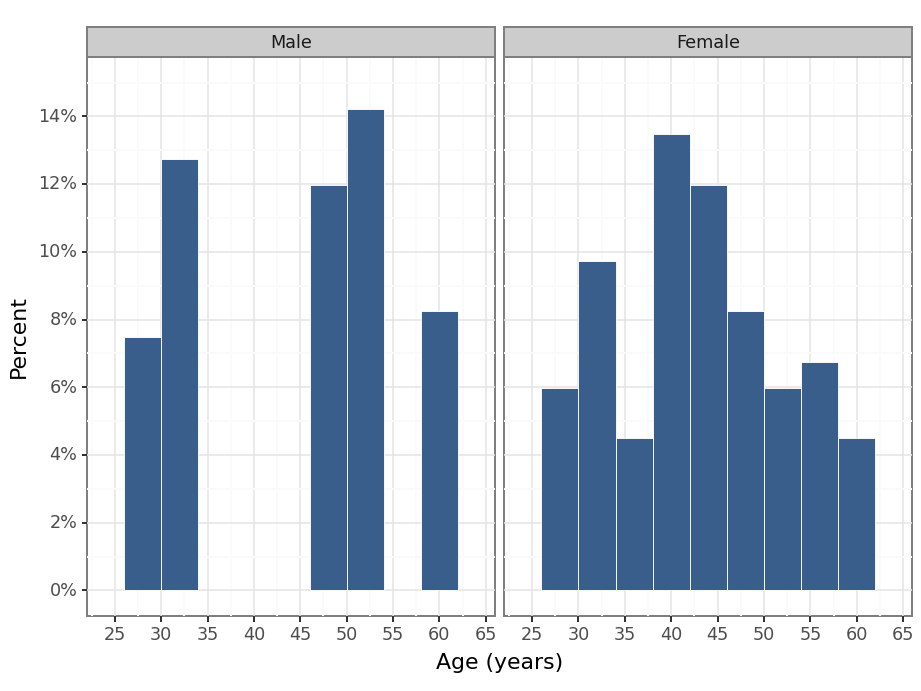

<Figure Size: (460 x 345)>

In [16]:
(
    ggplot(cps, aes(x="age", y="2*stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=4,
        color="white",
        fill=color[0],
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="Age (years)", y="Percent")
    + facet_wrap("~female", labeller={"0": "Male", "1": "Female"})
    + labs(x="Age (years)", y="Percent")
    + scale_x_continuous(
        limits=(24, 64),
        breaks=seq(25, 65, by=5),
    )
    + scale_y_continuous(
        limits=(0, 0.15), breaks=seq(0, 0.15, by=0.02), labels=percent_format()
    )
    + theme_bw()
)
#multiply y by 2 to see better

The age distribution of **male financial managers** shows that the largest age group is the 45-54 age group. 


The age distribution of **female financial managers** shows that the largest age group is the 30-49 age group. There is also a significant number of female employees in the 55-64 age group.

The population is older overall and there are more women than men in the older age groups. The graph also shows that the largest age group for male employees is the 45-54 age group, while the largest age group for female employees is the 30-49 age group.

**Density plots**: Kernel density estimates of age distribution of employees with a graduate degree separately for female and male

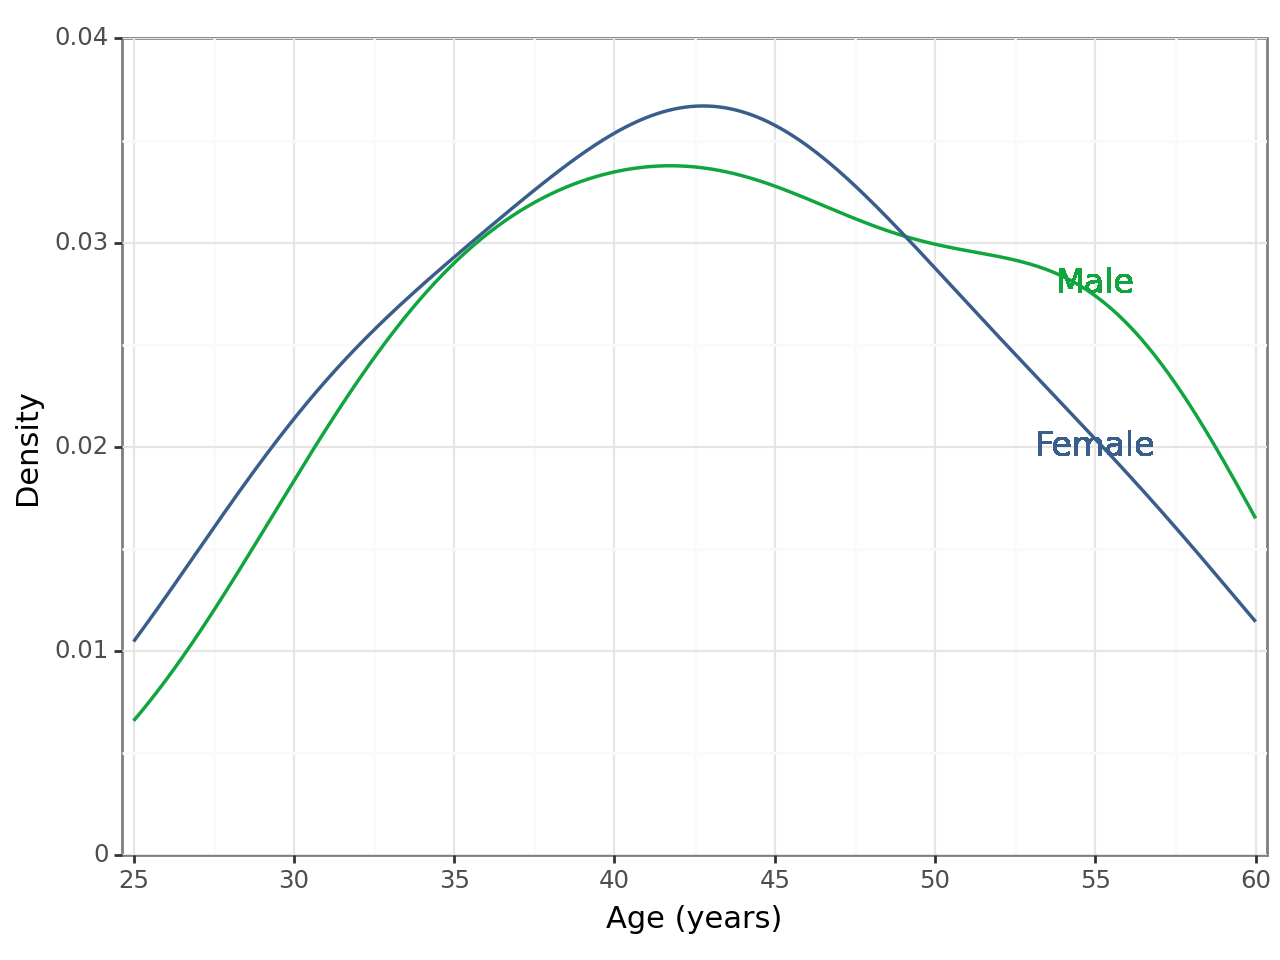

<Figure Size: (640 x 480)>

In [17]:
(
    ggplot(cps, aes(x="age", y="stat(density)", color="factor(female)"))
    + geom_density(adjust=1.5, show_legend=False, na_rm=True, size=0.7)
    + labs(x="Age (years)", y="Density", color="")
    + scale_color_manual(
        name="", values=(color[1], color[0]), labels=("Male", "Female")
    )
    + scale_x_continuous(expand=(0.01, 0.01), limits=(25, 60), breaks=seq(25, 60, by=5))
    + scale_y_continuous(
        expand=(0.0, 0.0), limits=(0, 0.04), breaks=seq(0, 0.04, by=0.01)
    )
    + geom_text(aes(x=55, y=0.028, label="'Male'"), color=color[1], size=12)
    + geom_text(aes(x=55, y=0.020, label="'Female'"), color=color[0], size=12)
    + theme_bw()
)